# Visualizing features with captum.optim

This notebook demonstrates the use of the `captum.optim` submodule for visualizing features for a MobileNetV2 model imported from `torchvision`. The `optim` submodule shows the increasing complexity of the features learned as we go deeper into the model. We also briefly touch on the `ImageTensor` class for easily loading and visualizing tensors that are also images.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.models import alexnet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## ImageTensor

The `ImageTensor` class is a wrapper around `torch.Tensor` that allows for easy loading and viewing of images.

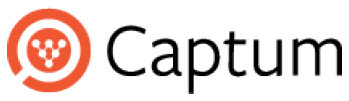

In [2]:
# Use ImageTensor.open() with a URL or filepath to load an image
t = optimviz.ImageTensor.open(
    "https://raw.githubusercontent.com/pytorch/captum/master/website/static/img/captum_logo.png"
)
# Use show() to quickly view the image.
t.show()

## InputOptimization

`InputOptimization` is the core function for visualizing features with `captum.optim`.

It takes five arguments:
- The model whose feature(s) we are visualizing
- A torch.nn.Module object that generates inputs to the model (e.g. NaturalImage)
- A transformation or series of transformations preprocessing the input before passing to the model
- A list of target layers from the model
- A loss function based on the target layers

/home/sweekiat/.local/lib/python3.8/site-packages/torch/tensor.py:605: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:840.)
  return super(Tensor, self).refine_names(names)


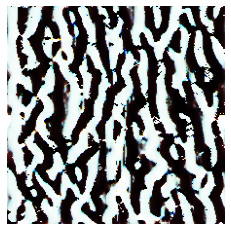

In [3]:
# Load the model
model = alexnet(pretrained=True).to(device)

# Initialize an input - NaturalImage uses FFT parameterization and color decorrelation
image = optimviz.images.NaturalImage((224, 224)).to(device) # This creates a Module that returns an ImageTensor

# Initialize a series of transformations
transforms = torch.nn.Sequential(
    # Normalization for torchvision models
    optimviz.transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Random translation and scaling to help with visualization quality
    optimviz.transform.RandomAffine(scale=(1, 0.975, 1.025, 0.95, 1.05), translate=tuple(range(-16, 16))),
)

# Choose a target layer to optimize
target = model.features[1]

# Create a loss function based on the target layer
loss_fn = optimviz.objectives.channel_activation(target, 5)

# Initialize InputOptimization and run optimize
obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
history = obj.optimize(optimviz.objectives.n_steps(128))

image().show()

For convenience, we can create a helper function for visualizing different layers in our model.

In [4]:
def visualize(model, target, channel):
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        optimviz.transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        optimviz.transform.RandomAffine(scale=True, translate=True),
    )
    loss_fn = optimviz.objectives.channel_activation(target, channel)
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128))
    image().show()

With visualization, we can see that deeper features detect for increasingly complex elements.

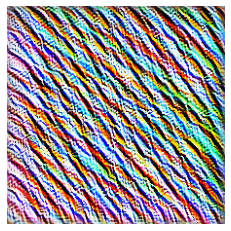

In [5]:
visualize(model, model.features[4], 15)

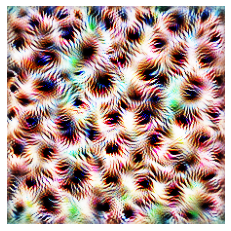

In [6]:
visualize(model, model.features[9], 8)

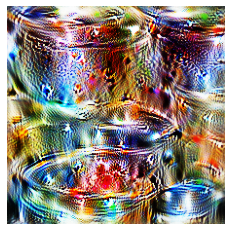

In [7]:
visualize(model, model.features[11], 14)

We can also visualize different classes in the final layer and see how they are similar to their corresponding ImageNet labels.

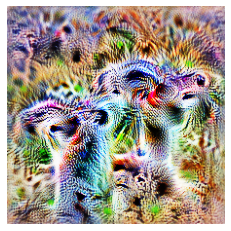

In [8]:
visualize(model, model.classifier[6], 9) # Ostrich

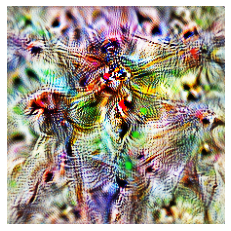

In [9]:
visualize(model, model.classifier[6], 319) # Dragonfly

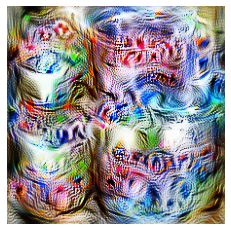

In [10]:
visualize(model, model.classifier[6], 999) # Toilet paper